<a href="https://colab.research.google.com/github/TonyPansera/Quantum-state-tomography/blob/main/ML_quantum_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
# librairies

!pip install qutip
import numpy as np
import pandas as pd
from qutip import basis, ket2dm, sigmax, sigmay, sigmaz, expect

from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
# -*- coding: utf-8 -*-
# Objectif:
# - Définir 4 états purs à 1 qubit : |0>, |1>, |+>, |i>
# - Pour chaque état, simuler 5 mesures projectives dans les bases de Pauli X, Y, Z
# - Stocker les résultats dans un DataFrame pandas


# -----------------------------
# 1) Définition des états purs
# -----------------------------

# |0> et |1> dans la base computationnelle
ket0 = basis(2, 0)                 # |0>
ket1 = basis(2, 1)                 # |1>

# |+> = (|0> + |1>)/sqrt(2)
ket_plus = (ket0 + ket1).unit()    # unit() normalise le vecteur

# |i> = (|0> + i|1>)/sqrt(2)
ket_i = (ket0 + 1j*ket1).unit()

states = {
    "0": ket0,
    "1": ket1,
    "+": ket_plus,
    "i": ket_i
}

# -------------------------------------------
# 2) Opérateurs de Pauli et mesures associées
# -------------------------------------------

paulis = {
    "X": sigmax(),   # σx
    "Y": sigmay(),   # σy
    "Z": sigmaz()    # σz
}

def sample_pauli_measurements(ket, pauli_op, n_shots=5, rng=None):
    """
    Simule n_shots mesures projectives de l'observable pauli_op sur l'état |psi>.
    Retourne une liste d'issues {+1, -1}.

    Principe:
    - On diagonalise pauli_op => eigenvalues (±1) et eigenkets
    - Probabilité de l'issue k: p_k = <psi|P_k|psi> = |<e_k|psi>|^2
    - On tire n_shots fois selon ces probabilités.
    """
    if rng is None:
        rng = np.random.default_rng()

    # Diagonalisation (spectre et états propres)
    eigvals, eigkets = pauli_op.eigenstates()

    # Probabilités Born p_k = <psi| (|e_k><e_k|) |psi>
    probs = np.array(
        [expect(ek * ek.dag(), ket) for ek in eigkets],  # projecteur |e_k><e_k|
        dtype=float
    )
    probs /= probs.sum()

    # Tirage aléatoire des outcomes selon probs
    outcomes = rng.choice(eigvals, size=n_shots, p=probs)

    # Conversion en float natif (eigvals Qutip -> numpy scalars)
    return [float(o) for o in outcomes]

# -----------------------------
# 3) Simulation et DataFrame
# -----------------------------

rng = np.random.default_rng(seed=42)  # seed pour reproductibilité

rows = []  # liste de lignes pour le DataFrame final

for label_state, ket in states.items():
    for basis_name, pauli_op in paulis.items():
        outcomes = sample_pauli_measurements(ket, pauli_op, n_shots=100, rng=rng)
        # On ajoute une ligne par "shot" (mesure individuelle)
        for shot_id, outcome in enumerate(outcomes, start=1):
            rows.append({
                "state": label_state,  # étiquette de l'état préparé
                "basis": basis_name,   # base de mesure (X,Y,Z)
                "shot": shot_id,       # numéro de mesure répétée
                "outcome": outcome     # résultat ±1
            })

df = pd.DataFrame(rows)

# Affiche le DataFrame
print(df)












# ! Création du CSV

df.to_csv("mesures_pauli.csv", index=False)

print("CSV généré : 100_mesures_pauli.csv")

     state basis  shot  outcome
0        0     X     1      1.0
1        0     X     2     -1.0
2        0     X     3      1.0
3        0     X     4      1.0
4        0     X     5     -1.0
...    ...   ...   ...      ...
1195     i     Z    96     -1.0
1196     i     Z    97     -1.0
1197     i     Z    98      1.0
1198     i     Z    99     -1.0
1199     i     Z   100      1.0

[1200 rows x 4 columns]
CSV généré : 100_mesures_pauli.csv


# Création du dataset que l'on va garder

In [6]:
# -*- coding: utf-8 -*-
# Objectif:
# - Définir 6 états purs à 1 qubit : |0>, |1>, |+>, |->, |i>, |-i>
# - Pour chaque état, simuler plusieurs mesures projectives dans les bases de Pauli X, Y, Z
# - Stocker les résultats dans un DataFrame pandas

import numpy as np
import pandas as pd
from qutip import basis, sigmax, sigmay, sigmaz, expect


# Définition des états purs
# |0> et |1> dans la base computationnelle
ket0 = basis(2, 0)                 # |0>
ket1 = basis(2, 1)                 # |1>

# |+> = (|0> + |1>)/sqrt(2)
ket_plus = (ket0 + ket1).unit()    # unit() normalise le vecteur
ket_moins = (ket0 - ket1).unit()

# |i> = (|0> + i|1>)/sqrt(2)
ket_i = (ket0 + 1j*ket1).unit()
ket_moins_i = (ket0 - 1j*ket1).unit()

states = {
    "0": ket0,
    "1": ket1,
    "+": ket_plus,
    "i": ket_i,
    "-": ket_moins,
    "-i": ket_moins_i
}


# Opérateurs de Pauli et mesures associées
paulis = {
    "X": sigmax(),   # σx
    "Y": sigmay(),   # σy
    "Z": sigmaz()    # σz
}

def sample_pauli_measurements(ket, pauli_op, n_shots, p_err=0.0, rng=None):
    """
    Simule n_shots mesures projectives de l'observable pauli_op sur l'état |psi>.
    Retourne une liste d'issues {+1, -1}.

    Principe:
    - On diagonalise pauli_op => eigenvalues (±1) et eigenkets
    - Probabilité de l'issue k: p_k = <psi|P_k|psi> = |<e_k|psi>|^2
    - On tire n_shots fois selon ces probabilités.
    """
    if rng is None:
        rng = np.random.default_rng()

    # Diagonalisation (spectre et états propres)
    # eigvals sont les valeurs propres
    # eigkets sont les vecteurs propres
    eigvals, eigkets = pauli_op.eigenstates()

    # Probabilités Born p_k = <psi| (|e_k><e_k|) |psi>
    # Calcule les probabilités de mesure de ket (ket)
    # dans la base des eigenkets fournis (ek * ek.dag() = A)
    probs = np.array(
        [expect(ek * ek.dag(), ket) for ek in eigkets],  # projecteur |e_k><e_k|
        dtype=float
    )
    probs /= probs.sum()

    # Tirage aléatoire des outcomes selon probs
    ideal_outcomes = rng.choice(eigvals, size=n_shots, p=probs)

    # --- AJOUT DU BRUIT DE MESURE ---
    if p_err > 0:
        flip_mask = rng.random(n_shots) < p_err   # booléen : True = flip
        noisy_outcomes = np.where(flip_mask, -ideal_outcomes, ideal_outcomes)
    else:
        noisy_outcomes = ideal_outcomes
    # --------------------------------

    # Conversion en float natif (eigvals Qutip -> numpy scalars)
    return [float(o) for o in noisy_outcomes]


def dataset_creation(n_shots, p_err=0.0):
    rows = []  # liste de lignes pour le DataFrame final

    for label_state, ket in states.items():
        for basis_name, pauli_op in paulis.items():
            outcomes = sample_pauli_measurements(ket, pauli_op, n_shots, p_err, rng=None)
            # On ajoute une ligne par "shot" (mesure individuelle)
            for shot_id, outcome in enumerate(outcomes, start=1):
                rows.append({
                    "state": label_state,  # étiquette de l'état préparé
                    "basis": basis_name,   # base de mesure (X,Y,Z)
                    "shot": shot_id,       # numéro de mesure répétée
                    "outcome": outcome     # résultat ±1
                })

    df = pd.DataFrame(rows)

    return df


# Parametres des datasets qu'on veut créer
nombre_shots = [100, 500, 1000]
error = [0.0, 0.02, 0.1]

# ! Création des CSVs !

for shots in nombre_shots:
    for err in error:
        dataframe = dataset_creation(shots, err)
        filename = f"mesures_pauli_err{err:.3f}_shots{shots}.csv"
        dataframe.to_csv(filename, index=False)

print("CSV générés")

CSV générés


In [7]:
df_mesures_pauli=pd.read_csv("mesures_pauli.csv")
df_mesures_pauli

,state,basis,shot,outcome
0,0,X,1,1.0
1,0,X,2,-1.0
2,0,X,3,1.0
3,0,X,4,1.0
4,0,X,5,-1.0
...,...,...,...,...
1195,i,Z,96,-1.0
1196,i,Z,97,-1.0
1197,i,Z,98,1.0
1198,i,Z,99,-1.0


# Histogrammes

array([[<Axes: title={'center': 'shot'}>,
        <Axes: title={'center': 'outcome'}>]], dtype=object)

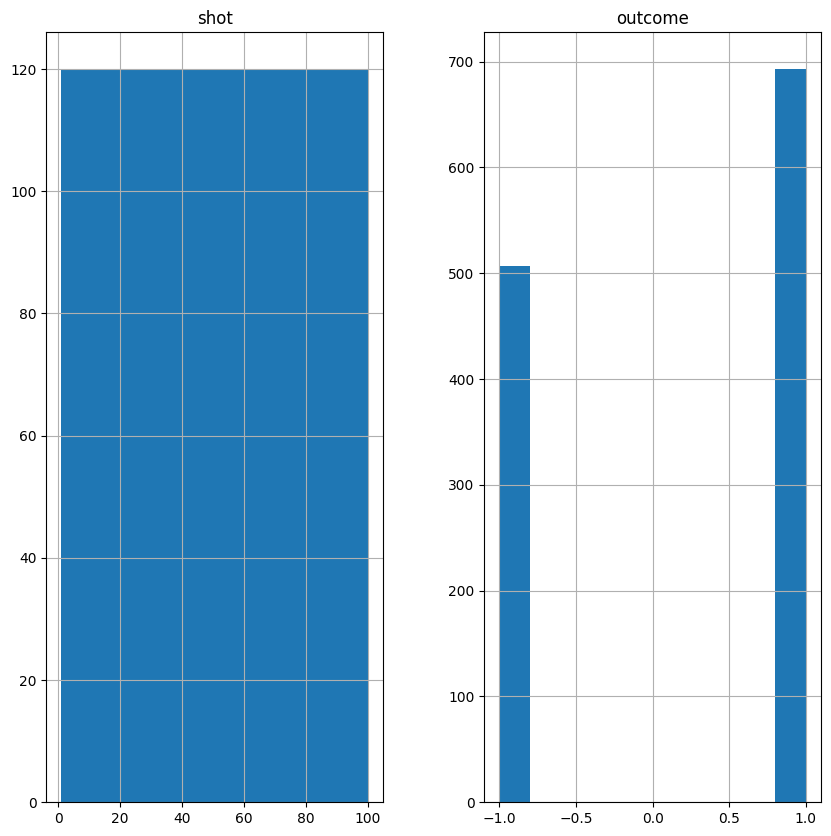

In [12]:
# affichage d'histogrammes unidimensionnels des variables du dataset "mesures_pauli"

df_mesures_pauli.hist(figsize=(10, 10))

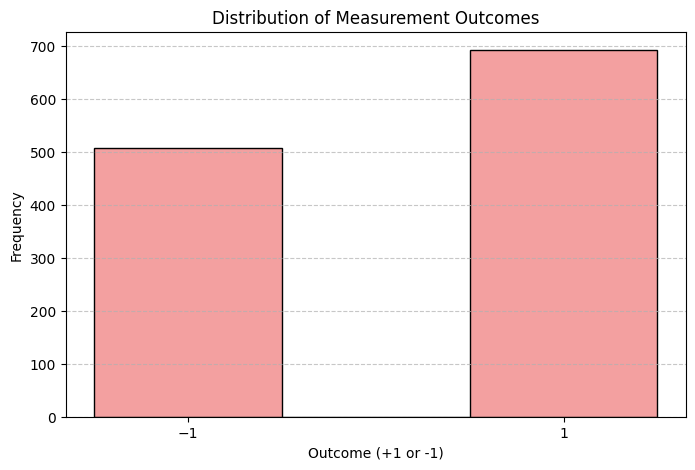

In [16]:
# Histogram for 'outcome' (numerical variable, though discrete)
plt.figure(figsize=(8, 5))
sns.histplot(data=df_mesures_pauli, x='outcome', bins=[-1.5, -0.5, 0.5, 1.5], discrete=True, color='lightcoral')
plt.title('Distribution of Measurement Outcomes')
plt.xlabel('Outcome (+1 or -1)')
plt.ylabel('Frequency')
plt.xticks([-1, 1])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

/tmp/ipython-input-962661428.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_mesures_pauli, x='state', palette='viridis')


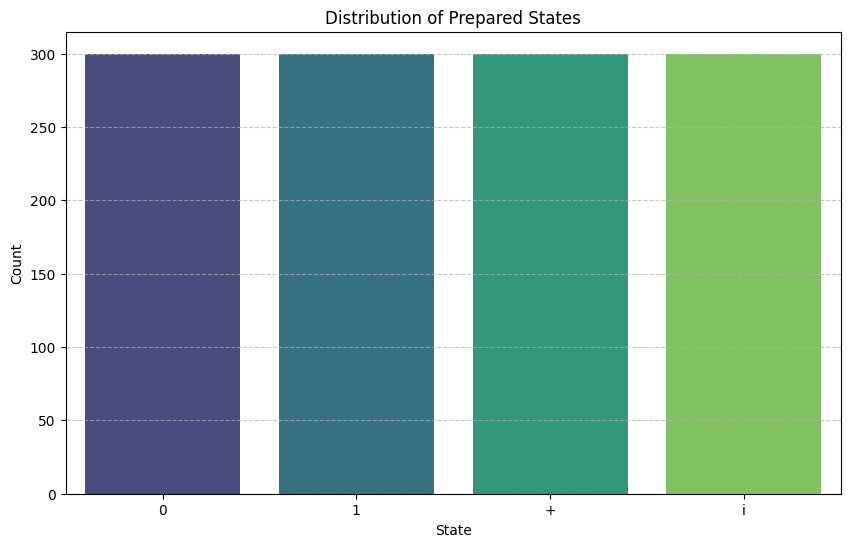

In [17]:
# Countplot for 'state' (categorical variable)
plt.figure(figsize=(10, 6))
sns.countplot(data=df_mesures_pauli, x='state', palette='viridis')
plt.title('Distribution of Prepared States')
plt.xlabel('State')
plt.ylabel('Count')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Remarque : le dataset est équilibré, tous les labels sont équilibrés.

/tmp/ipython-input-3098160934.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_mesures_pauli, x='basis', palette='magma')


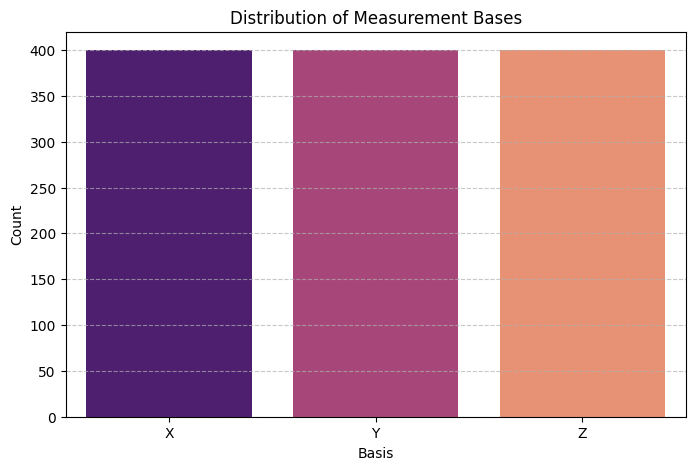

In [25]:
# Countplot for 'basis' (categorical variable)
plt.figure(figsize=(8, 5))
sns.countplot(data=df_mesures_pauli, x='basis', palette='magma')
plt.title('Distribution of Measurement Bases')
plt.xlabel('Basis')
plt.ylabel('Count')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Feature engineering

In [29]:
# conversion des bases en nombres entiers 0,1,2
basis_mapping = {
    'X': 0,
    'Y': 1,
    'Z': 2
}
df_mesures_pauli['basis'] = df_mesures_pauli['basis'].map(basis_mapping)

In [30]:
X=df_mesures_pauli.drop('state', axis=1)
y=df_mesures_pauli['state']

# Standard scale (on normalise aussi ou pas ?) et set splitting

In [42]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

scaler=StandardScaler()

X_scaler=scaler.fit_transform(X)
X_train, X_test, y_train, y_test=train_test_split(X_scaler,y,test_size=0.2,random_state=42)


array([[<Axes: title={'center': 'basis'}>,
        <Axes: title={'center': 'shot'}>],
       [<Axes: title={'center': 'outcome'}>, <Axes: >]], dtype=object)

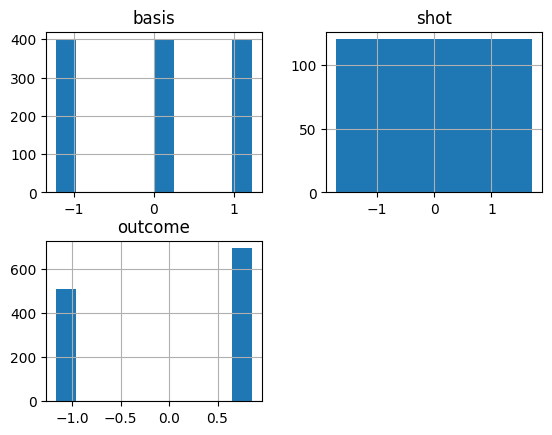

In [43]:
df_X_scaler=pd.DataFrame(X_scaler, columns=X.columns)
df_X_scaler.hist()

# Création et entrainement de SVC

In [35]:
from sklearn.svm import SVC

model_SVC=SVC(random_state=42)
model_SVC.fit(X_train,y_train)

y_pred_SVC=model_SVC.predict(X_test)



In [36]:
from sklearn.metrics import classification_report

print(classification_report(y_test,y_pred_SVC))

              precision    recall  f1-score   support

           +       0.43      0.48      0.45        60
           0       0.44      0.56      0.49        62
           1       0.38      0.32      0.35        60
           i       0.38      0.28      0.32        58

    accuracy                           0.41       240
   macro avg       0.41      0.41      0.40       240
weighted avg       0.41      0.41      0.40       240

